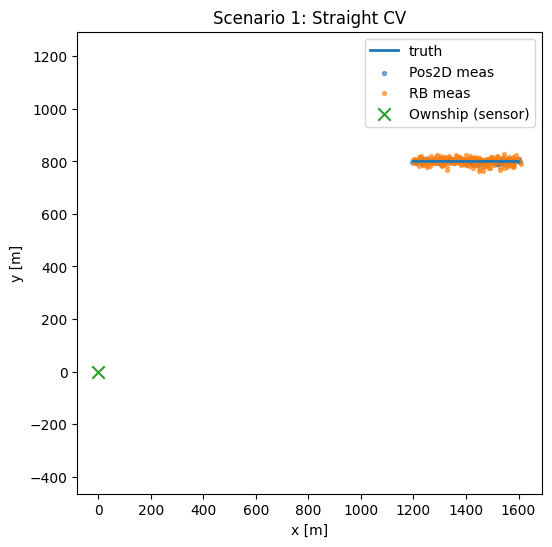

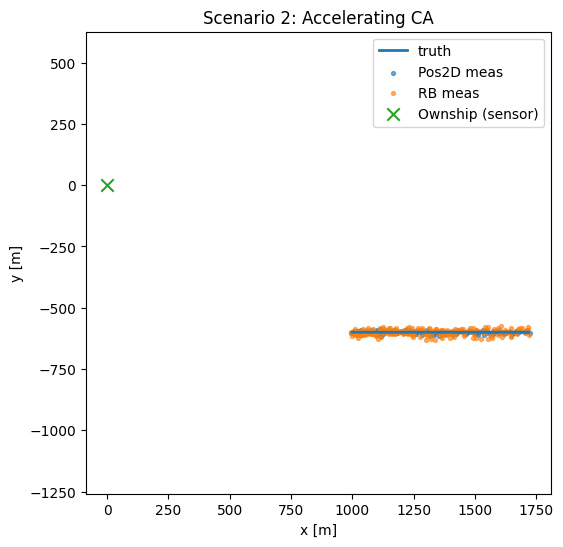

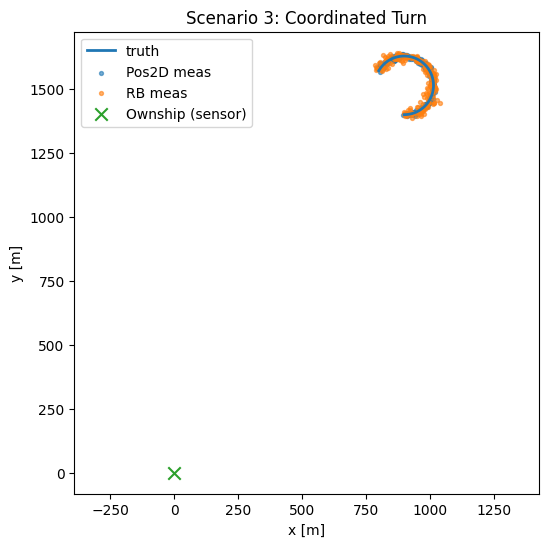

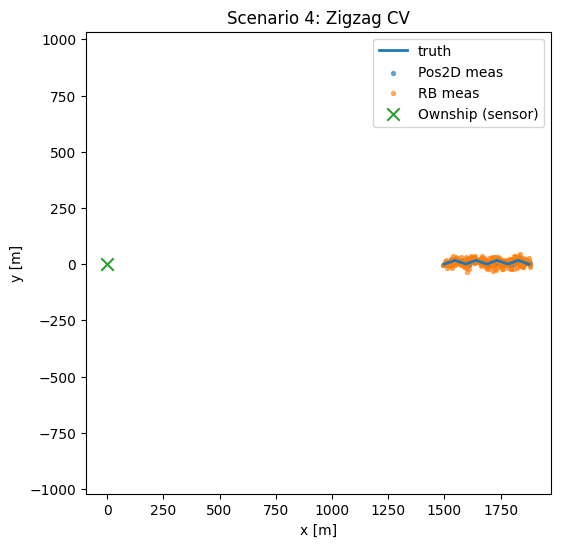

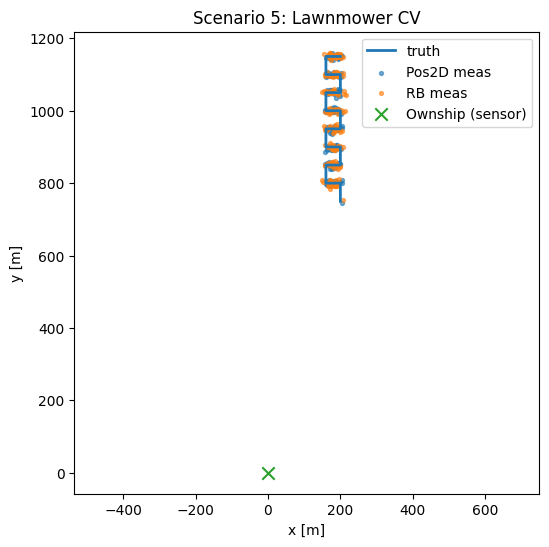

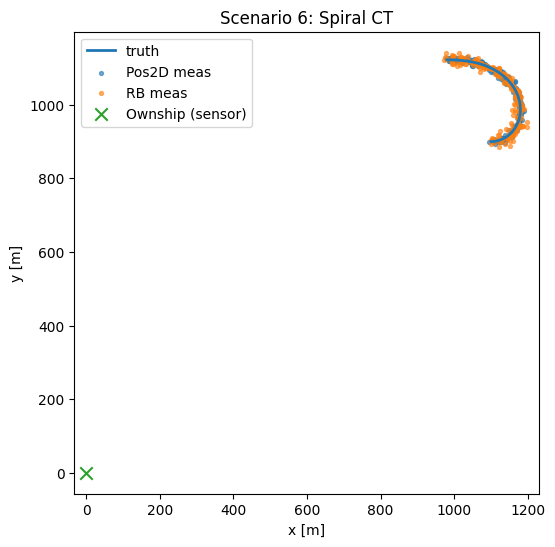

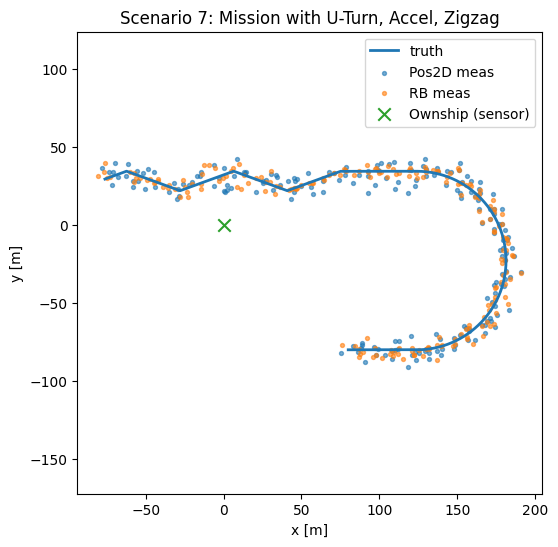

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from kf_lab.sims.scenarios import (
    straight_cv, accelerating_ca, ct_turn, zigzag_cv, lawnmower_cv, spiral_ct, mission_u_turn_accel_zigzag
)
from kf_lab.models.measurement.pos2d import Pos2D
from kf_lab.models.measurement.range_bearing import RangeBearing2D
from kf_lab.sensors.sampler import simulate_measurements

plt.rcParams["figure.figsize"] = (6, 6)

# Simulation settings
DURATION_S = 40.0
TRUTH_DT = 0.01
SENSOR_HZ = 5.0

# Sensor params
SIGMA_PX = SIGMA_PY = 5.0
RB_XS, RB_YS, RB_PSI = 0.0, 0.0, 0.0
SIGMA_R, SIGMA_B = 5.0, np.deg2rad(0.5)

offsets = [
    (1200, 800),   # straight_cv ~1.2 km
    (1000, -600),  # accelerating_ca ~1.0 km
    (900, 1400),   # ct_turn ~0.9–1.4 km
    (1500, 0),     # zigzag_cv ~1.5 km
    (200, 1200),   # lawnmower_cv closer lateral offset
    (1100, 900),   # spiral_ct ~1.1 km
    (80, -80),   # mission_u_turn_accel_zigzag ~0.8 km
]

def rb_to_xy(z_rb, xs=0.0, ys=0.0, psi_s=0.0):
    r = z_rb[:, 0]
    b = z_rb[:, 1] + psi_s
    x = xs + r * np.cos(b)
    y = ys + r * np.sin(b)
    return np.column_stack([x, y])

def plot_truth_with_measurements(title, truth_xyv, meas_pos2d=None, meas_rb=None):
    px, py = truth_xyv[:, 0], truth_xyv[:, 1]
    plt.figure()
    plt.plot(px, py, label="truth", linewidth=2)
    if meas_pos2d is not None:
        plt.scatter(meas_pos2d[:, 0], meas_pos2d[:, 1], s=8, alpha=0.6, label="Pos2D meas")
    if meas_rb is not None:
        rb_xy = rb_to_xy(meas_rb, xs=RB_XS, ys=RB_YS, psi_s=RB_PSI)
        plt.scatter(rb_xy[:, 0], rb_xy[:, 1], s=8, alpha=0.6, label="RB meas")
    plt.scatter([RB_XS], [RB_YS], marker='x', s=80, label="Ownship (sensor)")
    plt.axis("equal")
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    plt.title(title)
    plt.legend()
    plt.show()

# Helper to simulate both sensors and plot
def run_scenario(title, truth_func, offset):
    truth_result = truth_func(duration_s=DURATION_S, truth_dt=TRUTH_DT, offset_xy=offset)
    truth = truth_result[0] if isinstance(truth_result, tuple) else truth_result

    pos2d = Pos2D(sigma_px=SIGMA_PX, sigma_py=SIGMA_PY)
    rb = RangeBearing2D(xs=RB_XS, ys=RB_YS, psi_s=RB_PSI, sigma_r=SIGMA_R, sigma_b=SIGMA_B)

    _, Z_pos = simulate_measurements(truth, truth_result[1], pos2d, sensor_hz=SENSOR_HZ)
    _, Z_rb = simulate_measurements(truth, truth_result[1], rb, sensor_hz=SENSOR_HZ)

    plot_truth_with_measurements(title, truth, Z_pos, Z_rb)

# Run all scenarios
run_scenario("Scenario 1: Straight CV", straight_cv, offsets[0])
run_scenario("Scenario 2: Accelerating CA", accelerating_ca, offsets[1])
run_scenario("Scenario 3: Coordinated Turn", ct_turn, offsets[2])
run_scenario("Scenario 4: Zigzag CV", zigzag_cv, offsets[3])
run_scenario("Scenario 5: Lawnmower CV", lawnmower_cv, offsets[4])
run_scenario("Scenario 6: Spiral CT", spiral_ct, offsets[5])
run_scenario("Scenario 7: Mission with U-Turn, Accel, Zigzag", mission_u_turn_accel_zigzag, offsets[6])


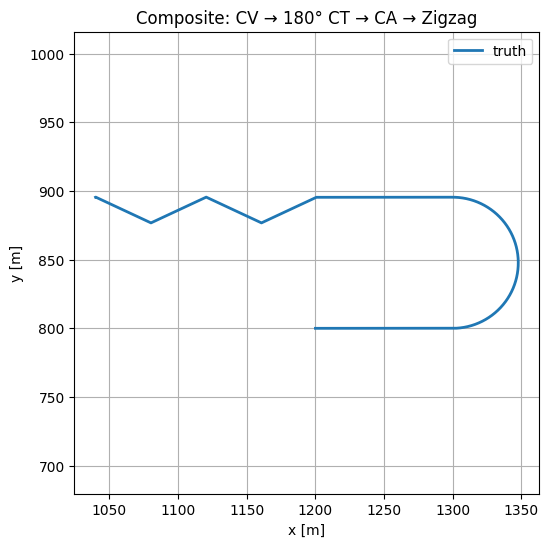

In [2]:
import matplotlib.pyplot as plt
from kf_lab.sims.scenarios import mission_u_turn_accel_zigzag

truth, t = mission_u_turn_accel_zigzag(
    truth_dt=0.01,
    t_cv1=10.0,            # straight run-in
    turn_rate_deg_s=12.0,  # faster/slower U-turn
    t_ca=8.0, a_mag=0.6,   # accelerate after turn
    t_zigzag=12.0, zigzag_deg=25.0, zigzag_T_seg=3.0,
    offset_xy=(1200.0, 800.0)
)

plt.figure(figsize=(6,6))
plt.plot(truth[:,0], truth[:,1], label="truth", linewidth=2)
plt.axis("equal"); plt.grid(True); plt.legend(); plt.xlabel("x [m]"); plt.ylabel("y [m]")
plt.title("Composite: CV → 180° CT → CA → Zigzag")
plt.show()
